# 0. 필요모듈 불러오기 및 wav 데이터 spectrogram으로 변환시키기

In [1]:
import numpy as np
import os
import IPython.display as ipd
import random
import pandas as pd


data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [3]:
spec = []
for wav in speech_data["wav_vals"]:
    spec.append(wav2spec(wav))
spec = np.array(spec)

In [4]:
print("Label data shape : ", spec.shape)
print("✅")

Label data shape :  (50620, 130, 126)
✅


# 1. Label Data 구성하기

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

# 2. 데이터 분리

In [7]:
from sklearn.model_selection import train_test_split

sr = 8000
train_spec, test_spec, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec)

#train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
#test_wav = test_wav.reshape([-1, sr, 1])
#print("✅")

[[[1.56338941e-02 5.98559994e-03 3.47525300e-03 ... 1.61023233e-02
   1.23506095e-02 5.27697708e-03]
  [2.15346459e-02 1.12866564e-02 2.52908980e-03 ... 1.01560950e-02
   1.06296027e-02 4.28791437e-03]
  [2.14749202e-02 1.86160617e-02 1.06057562e-02 ... 6.97972765e-03
   7.26849772e-03 5.27644157e-03]
  ...
  [3.00596468e-03 1.15958508e-03 4.40791278e-04 ... 5.89101168e-04
   1.83075608e-03 3.30822170e-03]
  [2.64436239e-03 1.41944748e-03 2.66541410e-05 ... 1.78418792e-04
   1.96623593e-03 3.62596102e-03]
  [2.73528649e-03 1.37464702e-03 1.92585703e-05 ... 5.60071458e-05
   1.73310982e-03 3.51327704e-03]]

 [[8.33426863e-02 3.70716117e-02 2.94636711e-02 ... 1.65238678e-02
   7.07592955e-03 7.80025199e-02]
  [2.55374834e-02 7.46496096e-02 7.90695846e-02 ... 6.57491758e-02
   7.85286501e-02 9.17160213e-02]
  [3.88107300e-02 7.72875845e-02 9.96010303e-02 ... 6.24491312e-02
   6.72701299e-02 5.00156544e-02]
  ...
  [1.22878011e-02 1.15630543e-02 7.61979120e-03 ... 2.47029020e-05
   1.19072

### ↳ 이미 Spectrogram으로 바뀌어서 reshape은 생략해주었다.

In [8]:
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126)
train labels :  (45558,)
test data :  (5062, 130, 126)
test labels :  (5062,)
✅


In [9]:
del speech_data
del spec

### ↳커널이 죽는 계속 현상이 계속 발생해 메모리를 날려준다

# 3. Hyper-Parameter Setting

In [10]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

checkpoint_dir

'/home/aiffel-dj53/aiffel/speech_recognition/models/spec'

# 4. tf.Dataset을 이용한 데이터 구성

In [11]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label
print("✅")

✅


In [12]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
✅


# 5. Spectrogram Classification Model 구현

In [13]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

### ↳ wav데이터와 달리 Spectrogram은 2차원적 데이터라 Conv1d에서 Conv2d로 변환시켜 모델을 구성하였다.

In [57]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [58]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


# 6. Training

In [16]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1422/1423 [============================>.] - ETA: 0s - loss: 0.7597 - accuracy: 0.7540
Epoch 00001: val_loss improved from inf to 0.48094, saving model to /home/aiffel-dj53/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 66s 47ms/step - loss: 0.7595 - accuracy: 0.7540 - val_loss: 0.4809 - val_accuracy: 0.8584
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9190
Epoch 00002: val_loss improved from 0.48094 to 0.21036, saving model to /home/aiffel-dj53/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================] - 62s 43ms/step - loss: 0.2626 - accuracy: 0.9190 - val_loss: 0.2104 - val_accuracy: 0.9343
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9502
Epoch 00003: val_loss improved from 0.21036 to 0.18153, saving model to /home/aiffel-dj53/aiffel/speech_recognition/models/spec_skip
1423/1423 [==============================

# 7. 학습결과 Plot

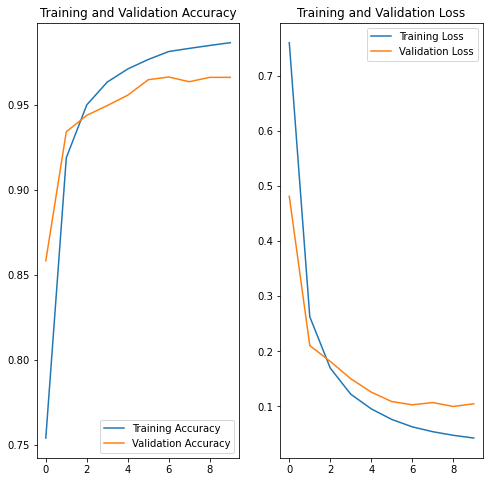

✅


In [59]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

# 8. 성능평가

In [20]:
# Evaluation 

model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 29s 180ms/step - loss: 0.0998 - accuracy: 0.9664
loss value: 0.100
accuracy value: 96.6416%
✅


### ↳96.64%로 꽤 훌륭한 성과를 보여준다

In [55]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

#ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  up


In [56]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: up(Correct!)
✅


### ↳ 랜덤테스트에서도 좋은 성과를 보여준다

---

# 회고

## 1. 이론적인 부분에서부터 난해했던 프로젝트였다. 음성데이터에 대한 기본적인 이론부터 시작하여,wav데이터가 어떠한 구조를 가지고 있는지, 그 구조를 어떻게 변형시켜 모델 구성을 하는지, Spectrogram까지 생소한 개념들이 많아 이해가 힘들었다.

## 2. 노드에서 일부 wav데이터를 spec으로 변환시키는 작업은 했었지만, 프로젝트를 위해 전체 데이터를 변환시키는 방법을 몰라 한참 고생했었다.

## 3. 유튜브를 시청할때 자동자막을 실행하면 꽤 좋은 음성 인식력을 보이곤했는데, 그 구조가 대충 어떻게 시행되는지 알수있는 기회였다.

## 4. 비록 이번 프로젝트에선 주먹구구식으로 진행했지만, 후에 조금 더 심도있게 공부하여 나만의 음성 인식기를 구현해보고싶다.